In [3]:
import numpy as np
from tools import *
from fitters import *
from plots import *
import seaborn as sns
sns.set_theme()
%load_ext autoreload
%autoreload 2


In [4]:
def test_run(noise=0, beta=0,  dim=6, alcs=[[1], [2.8], [0], [1]], start_end=(-1, 1), dt=0.01, iteration=0):

    time = np.arange(start_end[0], start_end[1]+dt, dt)
    a, l, c, s = alcs[0], alcs[1], alcs[2], alcs[3]
    X_series = build_signal_grid(time, noise=noise, a_s=a, l_s=l, c_s=c, s_s=s)

    # ALGO
    Xhan = build_hankel(X_series, dim)
    X0 = Xhan[:, :-1]
    Xp = Xhan[:, 1:]
    lam = beta * np.eye(dim)

    X0Xp = X0 @ Xp.T
    X0X0 = X0 @ X0.T
    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(
        X0Xp, (X0X0+lam), overwrite_a=True, overwrite_b=True)

    theta = vl[:, np.nanargmax(np.abs(w))]
    w = np.sort(np.abs(w))[::-1]

    theta /= theta[-1]
    pred_eig = theta.real @ Xhan
    pred_eig /= pred_eig[0]

    # X Corr
    X_centered = X_series - X_series.mean()
    XXT = np.outer(X_centered, X_centered.T)
    wXXt = np.sort(scipy.linalg.eig(XXT)[0])[::-1]

    result = {
        'Time': time,
        'X_series': X_series,
        'X_fft': np.fft.fft(X_series).real, 
        'fft_freq': np.fft.fftfreq(X_series.shape[-1]),
        'Pred Eig Left': pred_eig,
        'Eig Vec (REAL)': theta.real,
        'Eig Vec (IMAG)': theta.imag,
        'Eig Vals (MAG)': np.abs(w),
        'Eig Vals (REAL)': w.real,
        'Eig Vals (IMAG)': w.imag,
        'Spec X@XT': wXXt,
        'lam1': [np.exp(l[0]*dt)]*len(w),
        'lam2': [np.exp(-l[0]*dt)]*len(w),
        'Eig-X': np.arange(0,dim),
        'lam1-X': [0],
        'lam2-X': [1]

    }

    return result


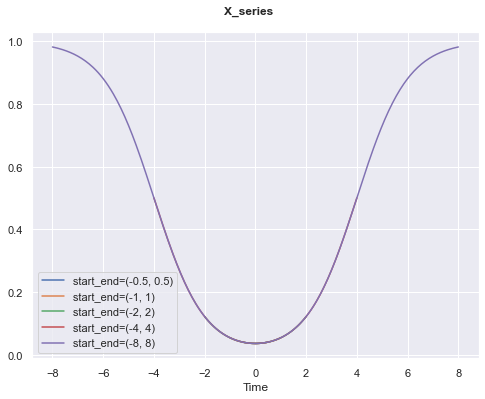

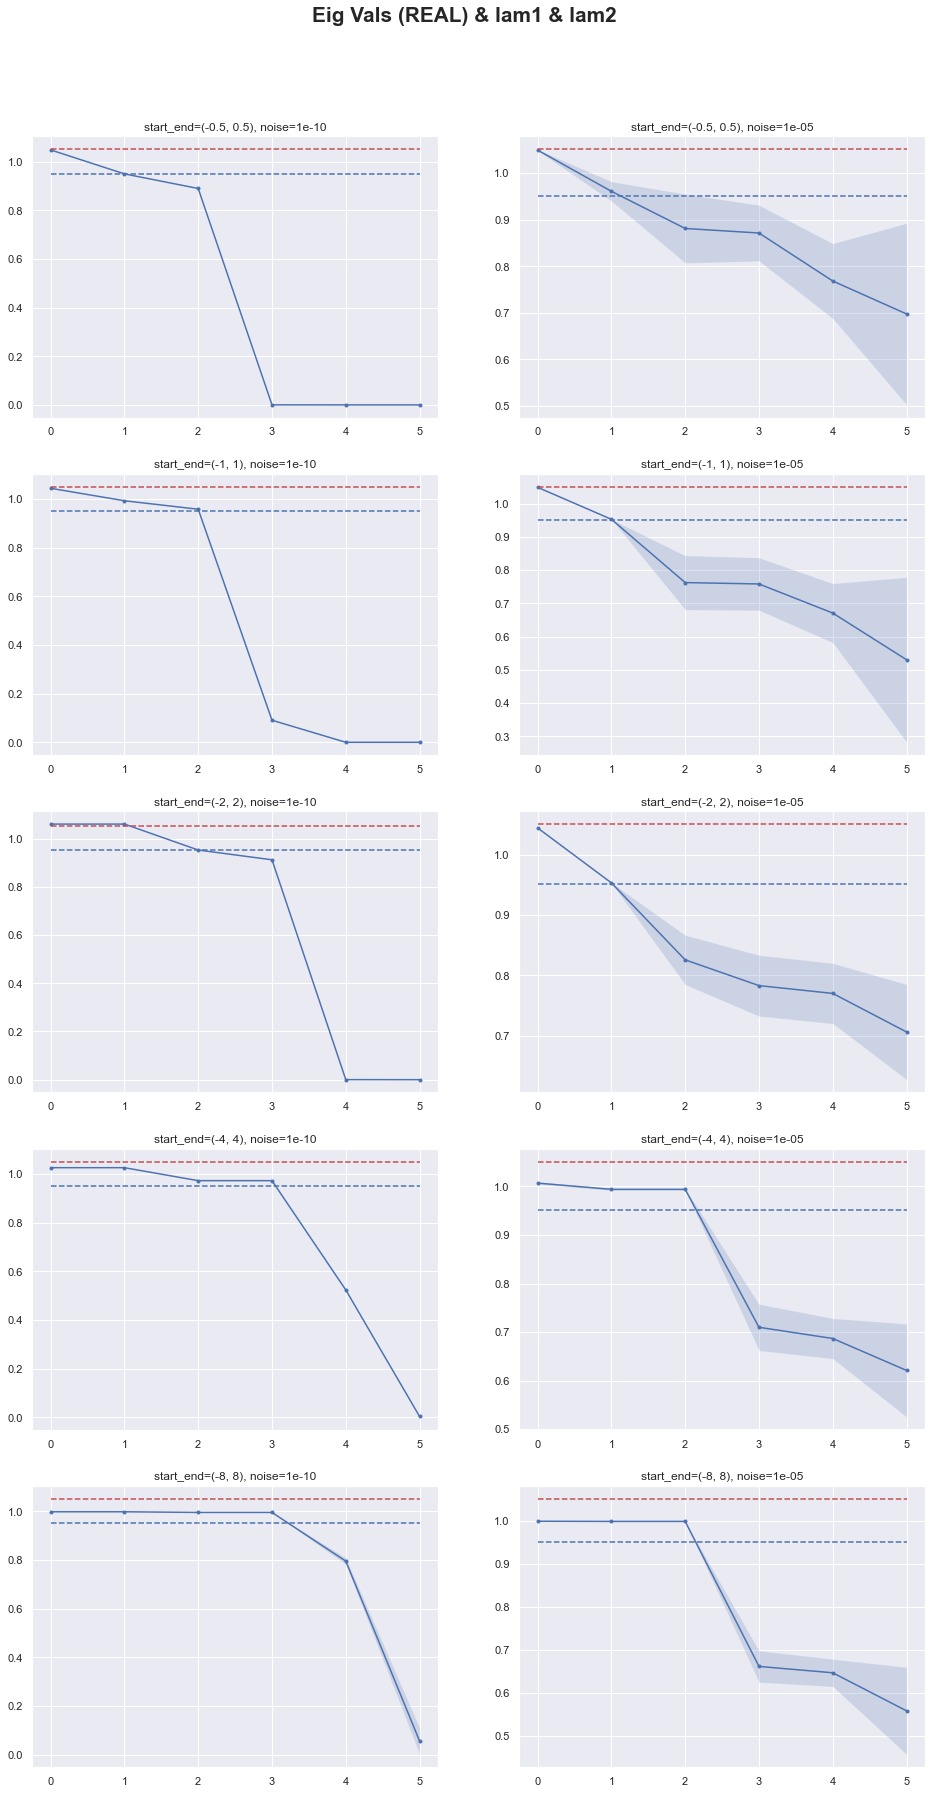

In [5]:
params = {
    'dt': [0.05],
    'noise': [1e-10,1e-5],
    'beta': [1e-12],
    'start_end': [(-8, 8),(-4, 4),(-2, 2),(-1, 1),(-0.5, 0.5)],
    'dim': [6],
    'alcs': [[[1, 1], [1, -1], [-4,4], [1, 1]]],
    'iteration': np.arange(30),
}
results = param_runner(test_run, params)
plot_dataframe(results, 'X_series',  x_col='Time',  line_cols = ['start_end'], aggregate='error', legend=True)
plot_dataframe(results, ['Eig Vals (REAL)', 'lam1', 'lam2'], title_cols=['start_end', 'noise'], legend=False,  val_styles=[['.-'], ['r--'], ['b--']])

In [8]:
def test_run(noise=0, beta=0,  dim=6, a_s=[], e_s=[], start_end=(-1, 1), n_series=2, dt=0.01, iteration=0):

    time = np.arange(start_end[0], start_end[1]+dt, dt)

    X0s = []
    Xps = []
    X_series_s = []

    for i in range(n_series):
        X_series, Y_series, _, _ = build_exp_series(
            a_s[i], e_s[i], noise=noise, time=time)
        Xhan = build_hankel(X_series, dim)
        X_series_s.append(X_series)

        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        X0Xp = X0 @ Xp.T
        X0X0 = X0 @ X0.T
        X0s.append(X0X0)
        Xps.append(X0Xp)

    X_series = np.concatenate(X_series_s)
    X0X0 = np.mean(X0s, axis=0)
    X0Xp = np.mean(Xps, axis=0)

    lam = beta * np.eye(dim)

    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(
        X0Xp, (X0X0+lam), overwrite_a=True, overwrite_b=True)

    vl =  vl[:, np.argsort(np.abs(w))[::-1]]
    theta = vl[:, 0]
    w = np.sort(np.abs(w))[::-1]

    theta /= theta[-1]
    Xhan = build_hankel(X_series, dim)
    pred_eig = theta.real @ Xhan
    pred_eig /= pred_eig[0]

    # compute lams
    max_es = e_s[:n_series].flatten()
    lams = np.exp(max_es*dt)
    lams = np.sort(lams)[::-1]

    result = {
        'Time': time,
        'X_series': X_series,
        'P_series': pred_eig,
        'Eig Vec (REAL)': theta.real,
        'Eig Vec (IMAG)': theta.imag,
        'Eig Vals (MAG)': np.abs(w),
        'Eig Vals (REAL)': w.real,
        'Eig Vals (IMAG)': w.imag,
        'lams': lams,
    }

    for i in range(min(n_series,dim)):
        result[f'EigVec{i}'] = vl[:, i].real

    return result



total_n_series = 20
series_rank = 1
draws = 1
shape = (draws, total_n_series, series_rank)
a_s = np.random.uniform(-1, 1, size=shape)
e_s = np.random.uniform(-1, 1, size=shape)

params = {
    'dt': [0.05],
    'noise': [1e-2],
    'beta': [1e-8],
    'dim': [6,10,20],
    'n_series': [2,4,6],
    'a_s': a_s,
    'e_s': e_s,
    'iteration': np.arange(20),
}
results = param_runner(test_run, params)



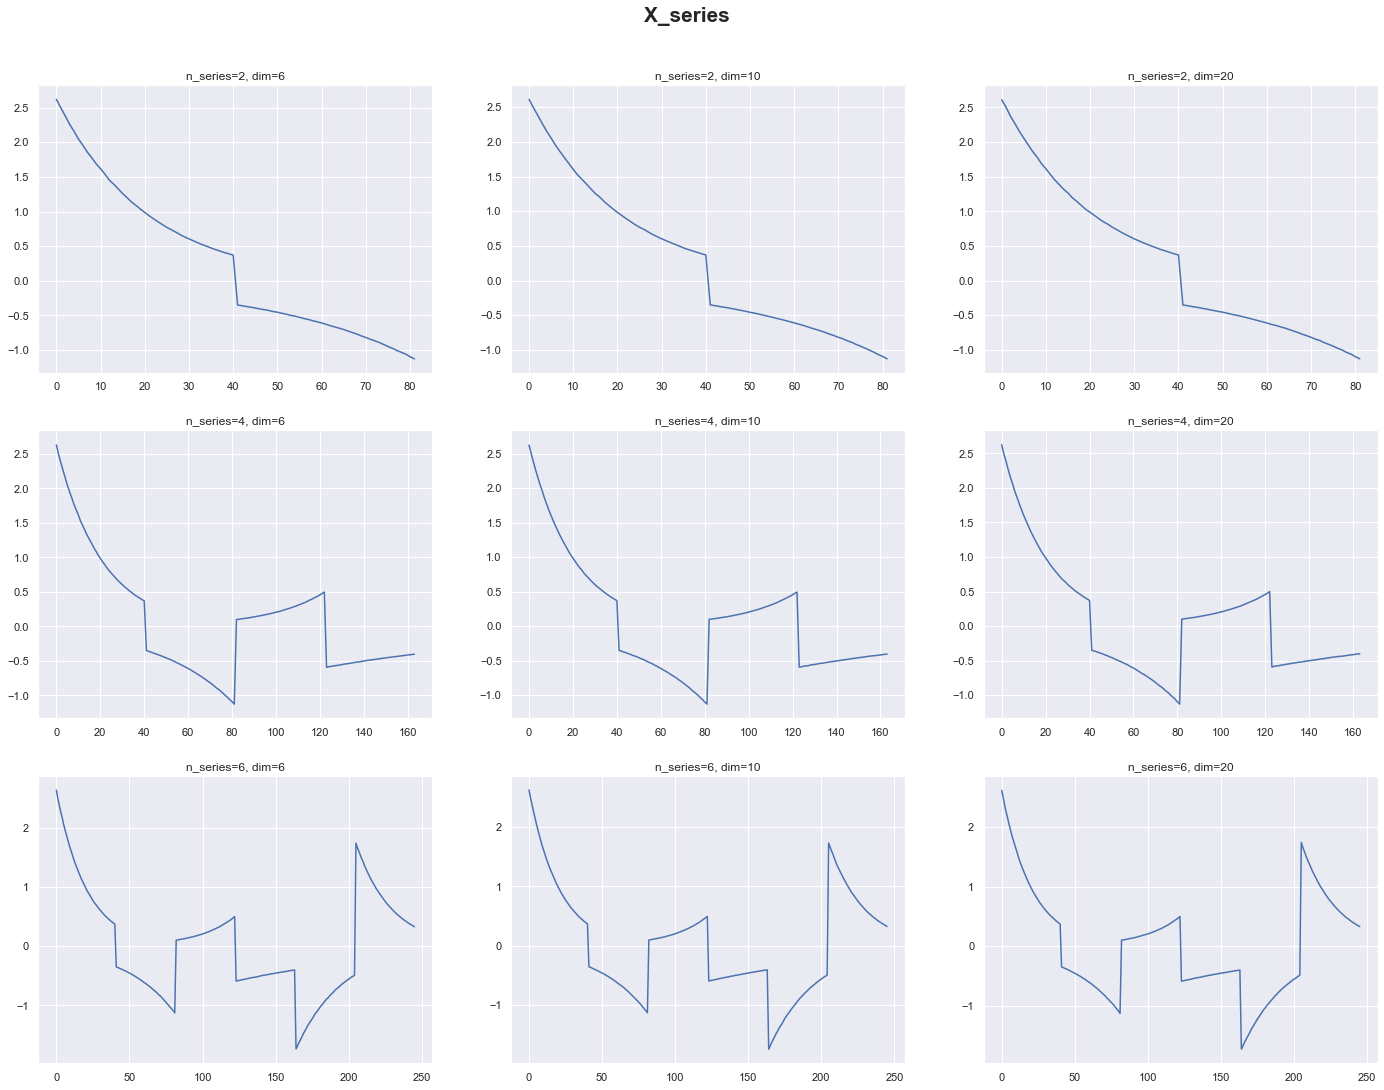

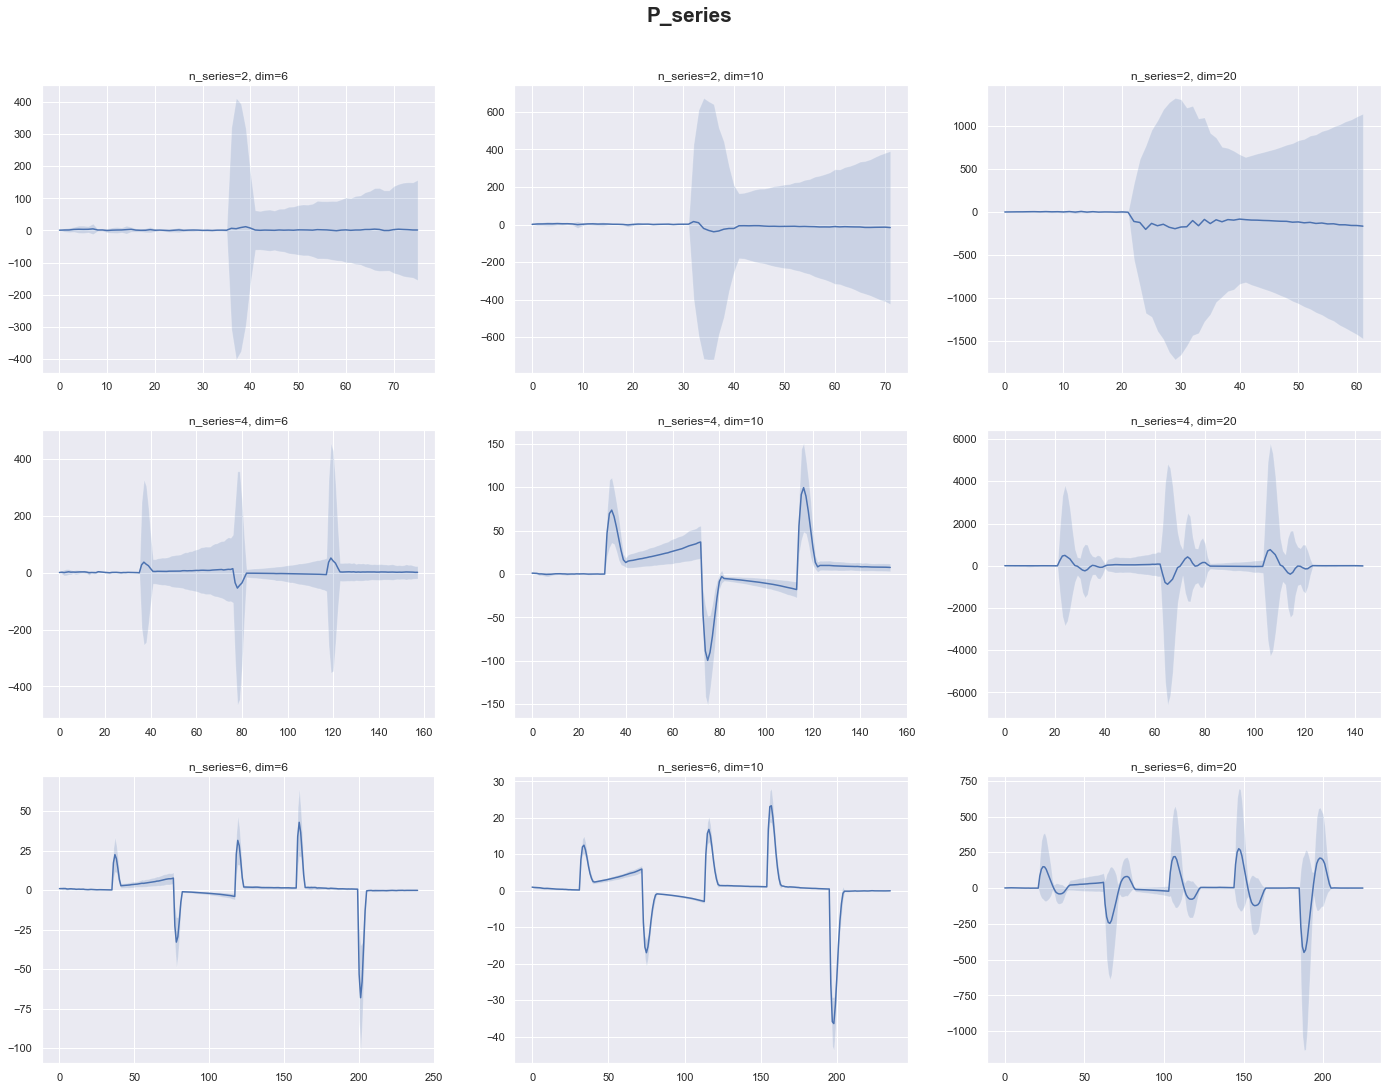

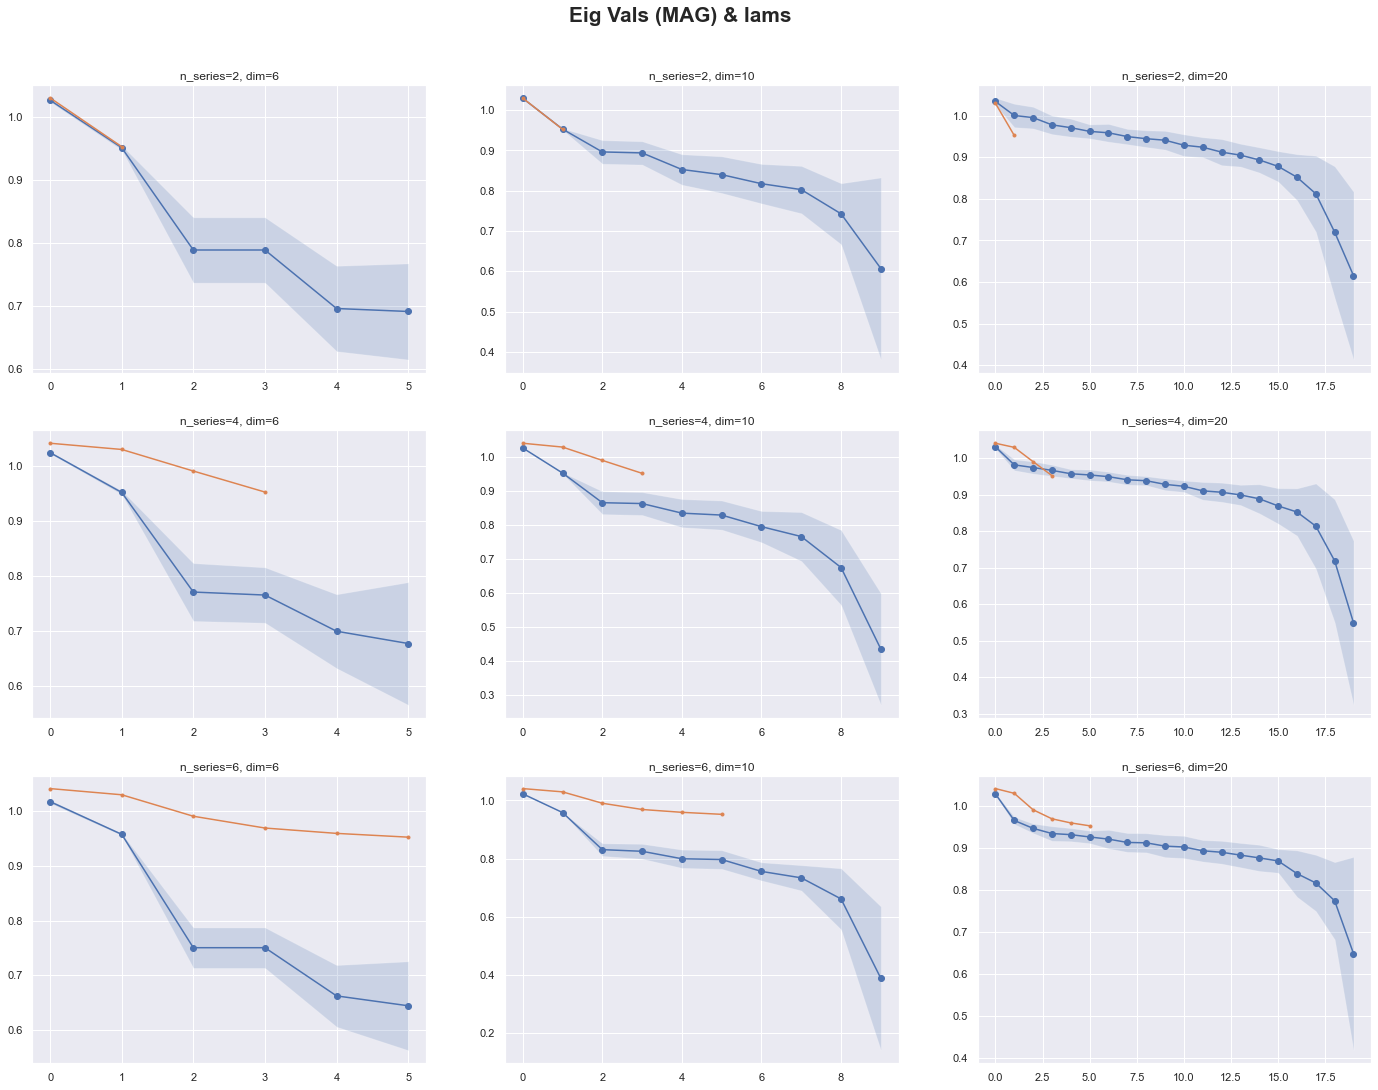

In [9]:
plot_dataframe(results, 'X_series', line_cols=['a_s', 'e_s', 'noise'], title_cols=['n_series', 'dim'], aggregate='error', legend=False)
# plot_dataframe(results, 'P_series', line_cols=['a_s', 'e_s', 'noise'], title_cols=['n_series', 'dim'], aggregate='error', legend=False)

# plot_dataframe(results, ['EigVec0','EigVec1','EigVec2','EigVec3'], line_cols=['a_s', 'e_s'], legend=False)
# plot_dataframe(results, ['Eig Vals (REAL)', 'lams'], line_cols=['a_s', 'e_s'], title_cols=['n_series', 'dim'], legend=False,  val_styles=[['-o'], ['.-']])
# plot_dataframe(results, ['Eig Vals (IMAG)', 'lams'], line_cols=['a_s', 'e_s'], title_cols=['n_series', 'dim'], legend=False,  val_styles=[['-o'], ['.-']])
plot_dataframe(results, ['Eig Vals (MAG)', 'lams'], line_cols=['a_s', 'e_s'], title_cols=['n_series', 'dim'], legend=False,  val_styles=[['-o'], ['.-']])
